In [2]:
# !git clone https://github.com/misbah4064/human-pose-estimation-opencv.git
# %cd human-pose-estimation-opencv/

In [3]:
from matplotlib import pyplot as plt
import mediapipe as mp
from tensorflow import keras
from keras.models import Model
from keras.layers import Dense
import pandas as pd
import cv2
import numpy as np
import math

In [4]:
import cv2 as cv
import numpy as np

BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }

POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

width = 368
height = 368
inWidth = width
inHeight = height

net = cv.dnn.readNetFromTensorflow("graph_opt.pb")
thr = 0.2

def poseDetector(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponging body's part.
        heatMap = out[0, i, :, :]

        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        points.append((int(x), int(y)) if conf > thr else None)
        

        # relbow_x, relbow_y = points[BODY_PARTS["RElbow"]]
        # lelbow_x, lelbow_y = points[BODY_PARTS["LElbow"]]
        # print(relbow_x)
        # print(relbow_y)
        # print(lelbow_x)
        # print(lelbow_y)


    for pair in POSE_PAIRS:
        partFrom = pair[0]
        partTo = pair[1]
        assert(partFrom in BODY_PARTS)
        assert(partTo in BODY_PARTS)

        idFrom = BODY_PARTS[partFrom]
        idTo = BODY_PARTS[partTo]

        if points[idFrom] and points[idTo]:
            cv.line(frame, points[idFrom], points[idTo], (0, 255, 0), 3)
            cv.ellipse(frame, points[idFrom], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)
            cv.ellipse(frame, points[idTo], (3, 3), 0, 0, 360, (0, 0, 255), cv.FILLED)

    t, _ = net.getPerfProfile()

    return frame

import cv2 as cv
import numpy as np

BODY_PARTS = { "Nose": 0, "Neck": 1, "RShoulder": 2, "RElbow": 3, "RWrist": 4,
               "LShoulder": 5, "LElbow": 6, "LWrist": 7, "RHip": 8, "RKnee": 9,
               "RAnkle": 10, "LHip": 11, "LKnee": 12, "LAnkle": 13, "REye": 14,
               "LEye": 15, "REar": 16, "LEar": 17, "Background": 18 }


#LElbowAngle = 8, 7, 6
#RElbowAngle = 5, 4, 3
#LShoulderAngle = 7, 6, 12
#RShoulderAngle = 4, 3, 9
#LHipsAngle = 6, 12, 13
#RHipsAngle = 3, 9, 10
#LKneeAngle = 12, 13, 14,
#RKneeAngle = 9, 10, 11,


POSE_PAIRS = [ ["Neck", "RShoulder"], ["Neck", "LShoulder"], ["RShoulder", "RElbow"],
               ["RElbow", "RWrist"], ["LShoulder", "LElbow"], ["LElbow", "LWrist"],
               ["Neck", "RHip"], ["RHip", "RKnee"], ["RKnee", "RAnkle"], ["Neck", "LHip"],
               ["LHip", "LKnee"], ["LKnee", "LAnkle"], ["Neck", "Nose"], ["Nose", "REye"],
               ["REye", "REar"], ["Nose", "LEye"], ["LEye", "LEar"] ]

width = 368
height = 368
inWidth = width
inHeight = height

net = cv.dnn.readNetFromTensorflow("graph_opt.pb")
thr = 0.1

def poseFrames(frame):
    frameWidth = frame.shape[1]
    frameHeight = frame.shape[0]
    
    net.setInput(cv.dnn.blobFromImage(frame, 1.0, (inWidth, inHeight), (127.5, 127.5, 127.5), swapRB=True, crop=False))
    out = net.forward()
    out = out[:, :19, :, :]  # MobileNet output [1, 57, -1, -1], we only need the first 19 elements

    assert(len(BODY_PARTS) == out.shape[1])

    points = []
    for i in range(len(BODY_PARTS)):
        # Slice heatmap of corresponding body's part.
        heatMap = out[0, i, :, :]

        _, conf, _, point = cv.minMaxLoc(heatMap)
        x = (frameWidth * point[0]) / out.shape[3]
        y = (frameHeight * point[1]) / out.shape[2]
        points.append((int(x), int(y)))
        
    return points

In [5]:
def calculate_angles(firstPoint, midPoint, lastPoint):
  # Same formula from the Android App for consistency
  result = math.degrees(math.atan2(lastPoint[1]  - midPoint[1], lastPoint[0] - midPoint[0]) - math.atan2(firstPoint[1] - midPoint[1], firstPoint[0] - midPoint[0]))
  result = abs(result) # Angle should never be negative
  # 
  if result > 180:
      result = 360.0 - result # Always get the acute representation of the angle
  return result

[(0, 73), (69, 59), (76, 59), (80, 66), (76, 80), (66, 59), (66, 69), (66, 73), (69, 76), (80, 93), (83, 114), (69, 76), (80, 93), (83, 114), (69, 55), (66, 52), (69, 52), (66, 52), (146, 156)]
135.0


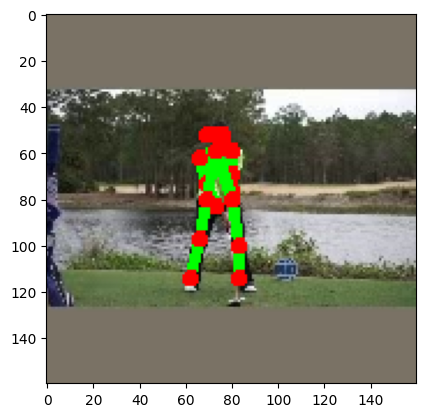

In [6]:
import matplotlib.pyplot as plt

input = cv.imread("127.jpg")
output = poseDetector(input)
outputFrame = poseFrames(input)

print(outputFrame)
#LElbowAngle = 8, 7, 6
#RElbowAngle = 5, 4, 3
#LShoulderAngle = 7, 6, 12
#RShoulderAngle = 4, 3, 9
#LHipsAngle = 6, 12, 13
#RHipsAngle = 3, 9, 10
#LKneeAngle = 12, 13, 14,
#RKneeAngle = 9, 10, 11,
LElbowAngle = calculate_angles(outputFrame[8], outputFrame[7], outputFrame[6])
RElbowAngle = calculate_angles(outputFrame[5], outputFrame[4], outputFrame[3]) 
LShoulderAngle = calculate_angles(outputFrame[7], outputFrame[6], outputFrame[12]) 
RShoulderAngle = calculate_angles(outputFrame[4], outputFrame[3], outputFrame[9]) 
LHipsAngle = calculate_angles(outputFrame[6], outputFrame[12], outputFrame[13]) 
RHipsAngle = calculate_angles(outputFrame[3], outputFrame[9], outputFrame[10]) 
LKneeAngle = calculate_angles(outputFrame[12], outputFrame[13], outputFrame[14]) 
RKneeAngle = calculate_angles(outputFrame[9], outputFrame[10], outputFrame[11]) 

print(LElbowAngle)

plt.imshow(cv.cvtColor(output, cv.COLOR_BGR2RGB))
plt.show()

In [7]:
# import cv2
# import os


# ctr = 0
# # Define the path to the directory containing the images
# image_dir = './GolfDB_Dataset/Address/'

# # Get a list of all the image filenames in the directory
# image_filenames = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)
#                    if os.path.isfile(os.path.join(image_dir, filename))]

# # Sort the filenames in ascending order by their numeric value
# image_filenames = sorted(image_filenames, key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))

# # Load the model
# net = cv2.dnn.readNetFromTensorflow('graph_opt.pb')

# # Define input and output sizes for the network
# inWidth = 368
# inHeight = 368

# # Iterate over the images in the directory
# for filename in image_filenames:
#     # Read in the image
#     frame = cv2.imread(filename)

#     # Get the pose frames for the image
#     pose_frames = poseFrames(frame)

#     # Calculate the angles from the pose frames
#     LElbowAngle = calculate_angles(pose_frames[8], pose_frames[7], pose_frames[6])
#     RElbowAngle = calculate_angles(pose_frames[5], pose_frames[4], pose_frames[3]) 
#     LShoulderAngle = calculate_angles(pose_frames[7], pose_frames[6], pose_frames[12]) 
#     RShoulderAngle = calculate_angles(pose_frames[4], pose_frames[3], pose_frames[9]) 
#     LHipsAngle = calculate_angles(pose_frames[6], pose_frames[12], pose_frames[13]) 
#     RHipsAngle = calculate_angles(pose_frames[3], pose_frames[9], pose_frames[10]) 
#     LKneeAngle = calculate_angles(pose_frames[12], pose_frames[13], pose_frames[14]) 
#     RKneeAngle = calculate_angles(pose_frames[9], pose_frames[10], pose_frames[11])

#     # Display the image with the pose frames
#     cv2.imshow('image', frame)

#     # Wait for a key to be pressed
#     key = cv2.waitKey(0) & 0xFF

#     # Check if 'q' was pressed to quit the loop
#     if key == ord('q'):
#         break

#     ctr += 1
#     if ctr >= 300:
#         break

# cv2.destroyAllWindows()

In [8]:

def draw_pose_lines(frame, pose_frames):
    # Define the colors for drawing the lines and points
    colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255)]

    # Define the connections between the body parts for drawing lines
    connections = [(0, 1), (1, 2), (2, 3), (3, 4), (1, 5), (5, 6), (6, 7), (1, 8), (8, 9), (9, 10), (10, 11),
                   (8, 12), (12, 13), (13, 14), (14, 15), (0, 16), (16, 17), (17, 18), (18, 19), (0, 15), (15, 22),
                   (22, 23), (23, 24), (0, 19), (19, 20), (20, 21)]

    # Iterate over the connections and draw the lines
    for connection in connections:
        start = pose_frames[connection[0]]
        end = pose_frames[connection[1]]
        cv2.line(frame, (int(start[0]), int(start[1])), (int(end[0]), int(end[1])), colors[0], 3)

    # Iterate over the pose frames and draw the points
    for pose_frame in pose_frames:
        cv2.circle(frame, (int(pose_frame[0]), int(pose_frame[1])), 5, colors[1], -1)

In [14]:
import cv2
import os



ctr = 0
# Define the path to the directory containing the images
image_dir = './GolfDB_Dataset/Mid-Follow-Through/'

# Get a list of all the image filenames in the directory
image_filenames = [os.path.join(image_dir, filename) for filename in os.listdir(image_dir)
                   if os.path.isfile(os.path.join(image_dir, filename))]

# Sort the filenames in ascending order by their numeric value
image_filenames = sorted(image_filenames, key=lambda x: int(os.path.splitext(os.path.basename(x))[0]))

# Load the model
net = cv2.dnn.readNetFromTensorflow('graph_opt.pb')

# Define input and output sizes for the network
inWidth = 368
inHeight = 368

for filename in image_filenames:
    # Read in the image
    frame = cv2.imread(filename)

    # Get the pose frames for the image
    pose_frames = poseFrames(frame)

    # Calculate the angles from the pose frames
    LElbowAngle = calculate_angles(pose_frames[8], pose_frames[7], pose_frames[6])
    RElbowAngle = calculate_angles(pose_frames[5], pose_frames[4], pose_frames[3]) 
    LShoulderAngle = calculate_angles(pose_frames[7], pose_frames[6], pose_frames[12]) 
    RShoulderAngle = calculate_angles(pose_frames[4], pose_frames[3], pose_frames[9]) 
    LHipsAngle = calculate_angles(pose_frames[6], pose_frames[12], pose_frames[13]) 
    RHipsAngle = calculate_angles(pose_frames[3], pose_frames[9], pose_frames[10]) 
    LKneeAngle = calculate_angles(pose_frames[12], pose_frames[13], pose_frames[14]) 
    RKneeAngle = calculate_angles(pose_frames[9], pose_frames[10], pose_frames[11])

    # print(LElbowAngle)
    # print(RElbowAngle)
    # print(LShoulderAngle)
    # print(RShoulderAngle)
    # print(LHipsAngle)
    # print(RHipsAngle)
    # print(LKneeAngle)
    # print(RKneeAngle)


     # Draw lines connecting the landmark points to form the pose
    cv2.line(frame, pose_frames[1], pose_frames[2], (0, 255, 255), 2)  # Neck to RShoulder
    cv2.line(frame, pose_frames[1], pose_frames[5], (0, 255, 255), 2)  # Neck to LShoulder
    cv2.line(frame, pose_frames[2], pose_frames[3], (0, 255, 255), 2)  # RShoulder to RElbow
    cv2.line(frame, pose_frames[3], pose_frames[4], (0, 255, 255), 2)  # RElbow to RWrist
    cv2.line(frame, pose_frames[5], pose_frames[6], (0, 255, 255), 2)  # LShoulder to LElbow
    cv2.line(frame, pose_frames[6], pose_frames[7], (0, 255, 255), 2)  # LElbow to LWrist
    cv2.line(frame, pose_frames[1], pose_frames[8], (0, 255, 255), 2)  # Neck to MidHip
    cv2.line(frame, pose_frames[8], pose_frames[9], (0, 255, 255), 2)  # MidHip to RHip
    cv2.line(frame, pose_frames[9], pose_frames[10], (0, 255, 255), 2)  # RHip to RKnee
    cv2.line(frame, pose_frames[10], pose_frames[11], (0, 255, 255), 2)  # RKnee to RAnkle
    cv2.line(frame, pose_frames[8], pose_frames[12], (0, 255, 255), 2)  # MidHip to LHip
    cv2.line(frame, pose_frames[12], pose_frames[13], (0, 255, 255), 2)  # LHip to LKnee
    cv2.line(frame, pose_frames[13], pose_frames[14], (0, 255, 255), 2)  # LKnee to LAnkle

    if (LElbowAngle is None or RElbowAngle is None or LShoulderAngle is None or
        RShoulderAngle is None or LHipsAngle is None or RHipsAngle is None or
        LKneeAngle is None or RKneeAngle is None or
        LElbowAngle == 0 or RElbowAngle == 0 or LShoulderAngle == 0 or
        RShoulderAngle == 0 or LHipsAngle == 0 or RHipsAngle == 0 or
        LKneeAngle == 0 or RKneeAngle == 0):
        print("Skipped - some angles are null or zero.")
    else:
        golfdataset = pd.DataFrame([[LElbowAngle, RElbowAngle, LShoulderAngle, RShoulderAngle, LHipsAngle, RHipsAngle, LKneeAngle, RKneeAngle, 5]], columns=['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', "Label"])
        golfdataset.to_csv('GolfOpenPoseData.csv', mode='a', index=False, header=False)
    

    # Display the image with the pose frames
    cv2.imshow('image', frame)

    
    # # Wait for a key to be pressed
    # key = cv2.waitKey(0) & 0xFF

    # # Check if 'q' was pressed to quit the loop
    # if key == ord('q'):
    #     break

    ctr += 1
    if ctr >= 450:
        break

cv2.destroyAllWindows()

Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
Skipped - some angles are null or zero.
